# Сборный проект

## Постановка общей задачи исследования

Из открытых источников доступны исторические данные о продажах игр интернет-магазином "Стримчик", оценки пользователей и экспертов, жанры и платформы.

Данные содержат сведения 3 видов:
- идентификационные характеристики игр (имя, дата релиза, жанр, игровая платформа, возрастной рейтинг);
- данные по продажам млн. копий на следующих рынках: Северная Америка, Европа, Япония, другие страны;
- данные о рейтинге игр: оценка критиков, пользовательская оценка.

В результате анализа данных необходимо выявить закономерности, определяющие успешность игр, чтобы определить потенциально популярный продукт для того, чтобы наиболее эффективно использовать средства для рекламной кампании.

## Получение и знакомство с данными

Импортируем библиотеки

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import seaborn as sns
import scipy.stats as st
import warnings
import os
from statistics import median

In [2]:
warnings.simplefilter("ignore")

Настроим параметры вывода

In [3]:
pd.options.display.max_columns = 200

Запишем данные csv-файлов в DataFrame-объекты (использую try-except, так как не знаю, в какой папке будет csv-файл на ревью)

In [4]:
try:
    games_df = pd.read_csv(os.path.join('under NDA'))
except:
    games_df = pd.read_csv('under NDA')

In [5]:
games_df.shape

(16715, 11)

Для того, чтобы рассмотреть в первом приближении данные, выведем интересующие параметры:

- структуру - методом `.head()`
- количество записей - методом `.len()`
- количество NaN-значений - методами `.isna()` и `.sum()`, а также `.isna().mean()*100` (вывод процентов пропусков)
- минимальное / максимальное количественные значения - методом `.describe()`
- типы данных - методом `.info()`

In [6]:
print('----------Структура таблицы----------')
display(games_df.head())
print('Количество записей в таблице (всего):', len(games_df))
print()
print('Количество пропущенных значений в таблице (всего):', games_df.isna().sum(axis=0).sum())
print()
print('Количество пропущенных значений, ед.')
display(games_df.isna().sum())
print()
print('Количество пропущенных значений, %')
display(round(games_df.isna().mean()*100), 1)
print()
print('----------Максимальные и минимальные значения в таблице----------')
display(games_df.describe().loc[['max', 'min']])
print()
print('----------Типы данных в таблице----------')
print()
display(games_df.info())

----------Структура таблицы----------


,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


Количество записей в таблице (всего): 16715

Количество пропущенных значений в таблице (всего): 22318

Количество пропущенных значений, ед.


Name                  2
Platform              0
Year_of_Release     269
Genre                 2
NA_sales              0
EU_sales              0
JP_sales              0
Other_sales           0
Critic_Score       8578
User_Score         6701
Rating             6766
dtype: int64


Количество пропущенных значений, %


Name                0.0
Platform            0.0
Year_of_Release     2.0
Genre               0.0
NA_sales            0.0
EU_sales            0.0
JP_sales            0.0
Other_sales         0.0
Critic_Score       51.0
User_Score         40.0
Rating             40.0
dtype: float64

1


----------Максимальные и минимальные значения в таблице----------


,Year_of_Release,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score
max,2016.0,41.36,28.96,10.22,10.57,98.0
min,1980.0,0.00,0.00,0.00,0.00,13.0



----------Типы данных в таблице----------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


None

### Вывод по разделу, формулирование предположения и задач для предобработки данных

Результаты рассмотрения данных:
- необходимо заменить названия колонок на названия в формате "snake_case";
- необходимо изменить типы данных в колонках: `User_Score - float, Year_of_Release - int`;
- заполнить пропущенные значения, по возможности, в колонках: Name, Year_of_Release, Critic_Score, User_Score, Rating;
- необходимо проверить соответствие данных доменным областям (возможным значениям) после изменения типов данных.

## Предобработка данных

### Постановка задачи для предобработки данных

- приведение названий столбцов к типу "snake_case";
- приведение данных в удобным для анализа типам данных `User_Score - float, Year_of_Release - int`;
- замена пропущенных значений адекватными задаче;
- создание отдельного столбца - суммарные продажи во всех регионах.

### Выполнение предобработки данных

#### Приведение названий столбцов к типу "snake_case"

Рассмотрим названия столбцов

In [7]:
games_df.columns

Index(['Name', 'Platform', 'Year_of_Release', 'Genre', 'NA_sales', 'EU_sales',
       'JP_sales', 'Other_sales', 'Critic_Score', 'User_Score', 'Rating'],
      dtype='object')

Для приведения названий к необходимому стилю достаточно изменить все буквы на прописные строковым методом `str.lower()`

In [8]:
games_df.columns = games_df.columns.str.lower()

In [9]:
# проверка
games_df.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

Названия колонок заменены

#### Приведение данных в удобным для анализа типам данных

Приведем значения колонок к следующим типам данных:
- `user_score - float`, 
- `year_of_release - int`.

Так как в колонке `user_score` встречаются NaN-значения, заменим NaN-значения на "заглушку" -1 и в дальнейшем для анализа данных не будем использовать эти строки.

In [10]:
games_df['user_score'].fillna(-1, inplace=True)

In [11]:
# проверка
print('Количество строк с пропущенными значениями в колонке user_score:', games_df['user_score'].isna().sum())

Количество строк с пропущенными значениями в колонке user_score: 0


In [12]:
# games_df['user_score'] = games_df['user_score'].astype('float', errors='raise')
# ValueError: could not convert string to float: 'tbd'

Мы попробовали конвертировать колонку в формат данных `float`, но в данных колонки оказалось значение `tbd` (часто означает 'to be defined' / 'должно быть определено'). Рассмотрим эти строки.

In [13]:
games_df[games_df['user_score'] == 'tbd'].head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
119,Zumba Fitness,Wii,2010.0,Sports,3.45,2.59,0.0,0.66,NaN,tbd,E
301,Namco Museum: 50th Anniversary,PS2,2005.0,Misc,2.08,1.35,0.0,0.54,61.0,tbd,E10+
520,Zumba Fitness 2,Wii,2011.0,Sports,1.51,1.03,0.0,0.27,NaN,tbd,T
645,uDraw Studio,Wii,2010.0,Misc,1.65,0.57,0.0,0.20,71.0,tbd,E
657,Frogger's Adventures: Temple of the Frog,GBA,NaN,Adventure,2.15,0.18,0.0,0.07,73.0,tbd,E


In [14]:
percent = len(games_df[games_df["user_score"] == "tbd"]) / len(games_df)
print('Процент "tbd"-значений {:.1%}'.format(percent))

Процент "tbd"-значений 14.5%


Значительный процент таких значений не позволяет их игнорировать. Целесообразно также заменить значение - "заглушку" -1, как и NaN-значения. В дальнейшем также не будем использовать эти строки для анализа корреляции каких-либо параметров с значениями user_score.

In [15]:
games_df.loc[games_df['user_score'] == 'tbd', 'user_score'] = -1

Проверяем, что `tbd`-значения в колонке `user_score` отсутствуют.

In [16]:
games_df[games_df['user_score'] == "tbd"]['name'].sum()

0

In [17]:
games_df['user_score'] = games_df['user_score'].astype('float', errors='raise')

In [18]:
# проверка
games_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       16715 non-null  float64
 10  rating           9949 non-null   object 
dtypes: float64(7), object(4)
memory usage: 1.4+ MB


В колонке `year_of_release` также есть пропущенные значения.

In [19]:
percent = games_df['year_of_release'].isna().sum() / len(games_df)
print('Процент "NaN"-значений {:.1%}'.format(percent))

Процент "NaN"-значений 1.6%


In [20]:
games_df[games_df['year_of_release'].isna()].head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,Madden NFL 2004,PS2,NaN,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E
377,FIFA Soccer 2004,PS2,NaN,Sports,0.59,2.36,0.04,0.51,84.0,6.4,E
456,LEGO Batman: The Videogame,Wii,NaN,Action,1.80,0.97,0.00,0.29,74.0,7.9,E10+
475,wwe Smackdown vs. Raw 2006,PS2,NaN,Fighting,1.57,1.02,0.00,0.41,NaN,-1.0,NaN
609,Space Invaders,2600,NaN,Shooter,2.36,0.14,0.00,0.03,NaN,-1.0,NaN


Так как количество таких записей не очень большое, можно было бы удалить, но в таком случаем мы потеряем данные по корреляции количества проданных копий игр и оценков пользователей / критиков. Предлагается оставить и заменить на -1. При этом необходимо помнить, что такие записи не должны участвовать в анализе, относящемуся к дате выпуска игры.

In [21]:
games_df['year_of_release'].fillna(-1, inplace=True)

In [22]:
games_df['year_of_release'] = games_df['year_of_release'].astype('int', errors='raise')

In [23]:
games_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16715 non-null  int32  
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       16715 non-null  float64
 10  rating           9949 non-null   object 
dtypes: float64(6), int32(1), object(4)
memory usage: 1.3+ MB


Значения колонок приведены к следующим типам данных:
- `user_score - float`, 
- `year_of_release - int`.

#### Анализ пропусков, их возможных причин, заполнение пропусков

Рассмотрим, какие пропуски существуют в данных.

In [24]:
games_df.isna().sum()

name                  2
platform              0
year_of_release       0
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score            0
rating             6766
dtype: int64

Рассмотрим пропуске в колонке с названиями игр `name`.

In [25]:
games_df[games_df['name'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993,NaN,1.78,0.53,0.00,0.08,NaN,-1.0,NaN
14244,NaN,GEN,1993,NaN,0.00,0.00,0.03,0.00,NaN,-1.0,NaN


Так как существует в рассматриваемой таблице всего 2 строки с отсутствующими данными о названиях игр, в т.ч. отсутствуют важный для анализа данные параметр 'жанр', предлагаем эти строки удалить, чем избавимся от строк с пропусками как в колонке `name`, так и в колонке `genre`.

In [26]:
games_df.dropna(subset=['name'], inplace=True)

In [27]:
# проверка
games_df.isna().sum()

name                  0
platform              0
year_of_release       0
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8576
user_score            0
rating             6764
dtype: int64

Видим существенное количество пропусков в колонке `critic_score`. Рассмотрим эти записи.

In [28]:
games_df[games_df['critic_score'].isna()].head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,-1.0,NaN
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,-1.0,NaN
5,Tetris,GB,1989,Puzzle,23.20,2.26,4.22,0.58,NaN,-1.0,NaN
9,Duck Hunt,NES,1984,Shooter,26.93,0.63,0.28,0.47,NaN,-1.0,NaN
10,Nintendogs,DS,2005,Simulation,9.05,10.95,1.93,2.74,NaN,-1.0,NaN


In [29]:
percent = len(games_df[games_df["critic_score"].isna()]) / len(games_df)
print('Процент "NaN"-значений {:.1%}'.format(percent))

Процент "NaN"-значений 51.3%


Значительный процент таких значений не позволяет их игнорировать. Целесообразно также заменить значение-"заглушку" -1, как и NaN-значения `user_score`. В дальнейшем также не будем использовать эти строки для анализа корреляции каких-либо параметров с значениями `critic_score`.

In [30]:
games_df['critic_score'].fillna(-1, inplace=True)

In [31]:
# проверка
games_df.isna().sum()

name                  0
platform              0
year_of_release       0
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score          0
user_score            0
rating             6764
dtype: int64

Видим существенное количество пропусков в колонке `rating`. Рассмотрим эти записи.

In [32]:
games_df[games_df['rating'].isna()].head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,-1.0,-1.0,NaN
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,-1.0,-1.0,NaN
5,Tetris,GB,1989,Puzzle,23.20,2.26,4.22,0.58,-1.0,-1.0,NaN
9,Duck Hunt,NES,1984,Shooter,26.93,0.63,0.28,0.47,-1.0,-1.0,NaN
10,Nintendogs,DS,2005,Simulation,9.05,10.95,1.93,2.74,-1.0,-1.0,NaN


In [33]:
games_df['rating'].unique()

array(['E', nan, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

Заменим `NaN`-значения на 'Unknown'

In [34]:
games_df['rating'].fillna('Unknown', inplace=True)

Рассмотрим распределение рейтингов по количеству игр

In [35]:
games_df['rating'].value_counts()

Unknown    6764
E          3990
T          2961
M          1563
E10+       1420
EC            8
K-A           3
RP            3
AO            1
Name: rating, dtype: int64

Видим, что рейтинги `EC` (Для детей младшего возраста), `RP` (Рейтинг ожидается), `K-A` (Kids to adults, для младшего возраста), `AO` (только для взрослых) состявляют незначительную часть всех игр. Целесообразно их привести к наиболее близкой возрастной категории. Предлагаемые трансформации рейтинга:
- EC - к рейтингу E (для всех);
- RP - к рейтингу Unknown;
- K-A - к рейтингу E (для всех);
- AO - к рейтингу M (для взрослых).

Для автоматизации замены создадим соответстующий словарь, а затем в цикле заменим все необходимые значения на соответствующие.

In [36]:
rating_dict = {'EC': 'E', 'RP': 'Unknown', 'K-A': 'E', 'AO': 'M'}

In [37]:
for original_rate, replacing_rate in rating_dict.items():
    games_df.loc[games_df['rating'] == original_rate, 'rating'] = replacing_rate

In [38]:
# проверка
games_df['rating'].value_counts()

Unknown    6767
E          4001
T          2961
M          1564
E10+       1420
Name: rating, dtype: int64

In [39]:
print('Количество пропущенных значений в таблице (всего):', games_df.isna().sum(axis=0).sum())

Количество пропущенных значений в таблице (всего): 0


**Промежуточные выводы о возможных причинах пропусков**

В исходной таблице были замечены пропуски в колонках:
- `name`: 2 пропущенных значения. Для этих записей были пропущенны значения ещё несколькых колонок, однако значения продаж были не нулевые. Скорее всего, данные пропуски связаны с технической ошибкой выгрузки данных.
- `year_of_release`: 269 пропущенных значений. Скорее всего, данные пропуски связаны с технической ошибкой выгрузки данных, так как некоторые игры имеют в названиях указание года, например, "Madden NFL 2004". Можно было бы провести замену года выпуска на основании года в названии игр, однако это довольно ненадежно, так как действительный релиз мог быть в иной год, близкий, но другой.
- `critic_score`, `user_score`, `rating`: пропусков в этих колонках довольно много (40-50% от общего количества записей). Причинами может быть действительное отсутствие этих данных, ошибки в сборе и хранении данных, ошибки при выгрузке данных. В данном случае имеет смысл выяснить пичины отсутвия данных у инженера по базам данных (или другого специалиста, ответственного за хранение данных) или ручная выборочная проверка записей в источнике выгрузки (например, если выгрузка происходила с помощью парсинга web-сайта).

#### Проверка на дубликаты

In [40]:
print('Количество дубликатов строк:', games_df.duplicated().sum())

Количество дубликатов строк: 0


#### Создание отдельного столбца - суммарные продажи во всех регионах

In [41]:
games_df['total_sales'] = games_df[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].sum(axis=1)

In [42]:
# проверка
games_df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,-1.0,-1.0,Unknown,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,-1.0,-1.0,Unknown,31.38


### Вывод по разделу предобработки данных

В данном разделе мы выпоонили следующие операции над таблицей с данными:
- привели названия столбцов к типу "snake_case";
- привели данные в удобные для анализа типы данных `User_Score - float, Year_of_Release - int`;
- заполнили пропущенные значения (в основном, числовым значением, отличным от доменной области -1 для того, чтобы при дальнейшем анализе не использовать эти записи при расчете, например, корреляции);
- укрупнили возрасные категории игр (заменили мало встречающиеся значения категорий на часто встречающиеся, соответствующие исходной возрастной категории);
- создали отдельный столбец - суммарные продажи во всех регионах.

## Исследовательский анализ данных

### Постановка задачи для исследовательского анализа данных

- Расчёт количества игр, выпускавшихся в разные годы.
- Расчёт изменений продаж по платформам. Поиск платформ с наибольшими суммарными продажами, построение распределения по годам.
- Определение актуального временного периода.
- Определение платформ - лидиров продаж.
- Построение бокс-плота для глобальных продаж платформ - лидиров.
- Построение диаграммы рассеяния и расчёт корреляции между отзывами и продажами внутри самой популярной платформы.
- Соотнесение выводов с продажами игр на других платформах.
- Посмотрите на общее распределение игр по жанрам. Что можно сказать о самых прибыльных жанрах? Выделяются ли жанры с высокими и низкими продажами?

### Исследовательский анализ данных

#### Cколько игр выпускалось в разные годы

Создадим график зависимости количества игр от года.

Так как одни и те же игры могут выпускаться на различных платформах, создадим таблицу с уникальными названиями игр, сохранив только записи их первого релиза, а остальные удалим.

In [43]:
unique_games_df = games_df.query("year_of_release > 0") \
                            .sort_values(by='year_of_release') \
                            .drop_duplicates(subset=['name'], keep='first')

Построим график для обоих таблиц

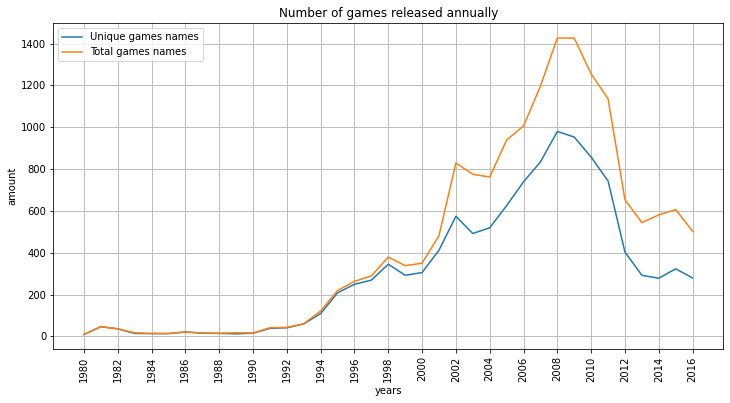

In [44]:
unique_games_df.groupby('year_of_release') \
                .count() \
                .name \
                .plot(grid=True, figsize=(12, 6), xlabel='years', ylabel='amount', title='Number of games released annually', label = 'Unique games names')
games_df.query('year_of_release != -1') \
                .groupby('year_of_release') \
                .count() \
                .name \
                .plot(grid=True, figsize=(12, 6), xlabel='years', ylabel='amount', title='Number of games released annually', label ='Total games names')
plt.xticks(list(range(1980, 2017, 2)), rotation=90)
plt.legend()
plt.show()

По графику заметно, что основной пик производства игр пришелся на 2005 - 2011 г. Данные за 2016 г. неполные, поэтому наблюдается "падение".

Для общего анализа игр нецелесообразно учитывать период 1980 - 1992, так как общее количество выпускаемых довольно низко и свидетельствует о зарождении индустрии. С 1992 года наблюдается устойчивый рост.

Для дальнейшего анализа предлагается использовать таблицу с удаленными записями об играх, выпущенных c 1980 до 1992 года включительно, однако необходимо помнить, что есть записи с годом релиза `-1` (заглушка для неуказанных значений).

In [45]:
games_df_since_1993 = games_df[~games_df['year_of_release'].isin(range(1980, 1993))]

Построим график обновленной таблицы для игр с 2013 г. для всех записей, игнорируя то, что одни и те же игры выпускались для разных платформ.

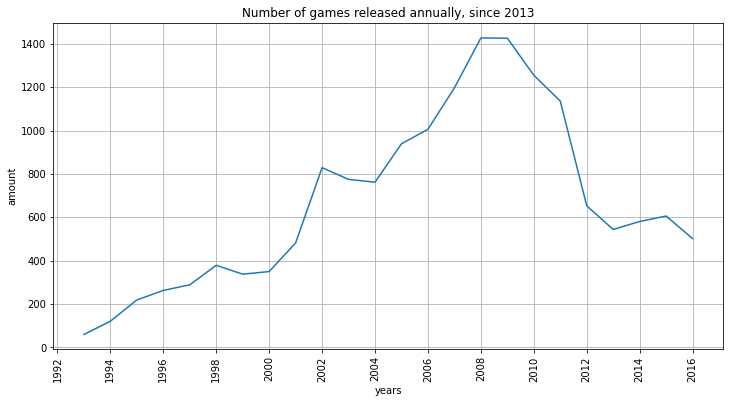

In [46]:
games_df_since_1993.query('year_of_release != -1') \
                    .groupby('year_of_release') \
                    .count() \
                    .name \
                    .plot(grid=True, figsize=(12, 6), xlabel='years', ylabel='amount', title='Number of games released annually, since 2013')
plt.xticks(list(range(1992, 2017, 2)), rotation=90)
plt.show()

#### Изменения продаж по платформам

Выберем платформы с наибольшими суммарными продажами за период с 1993 г.

In [47]:
top_10_platforms = games_df_since_1993.groupby('platform') \
                                    .agg({'total_sales': 'sum'}) \
                                    .sort_values(by='total_sales', ascending=False) \
                                    .head(10)

In [48]:
# проверка
top_10_platforms.index

Index(['PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS', 'GBA', 'PS4', 'PSP', '3DS'], dtype='object', name='platform')

Создадим таблицу с данными количества выпущенных игр (`number_of_games`) в разрезе лет и платформ

In [49]:
games_df_by_year = games_df_since_1993 \
                    .query("platform in @top_10_platforms.index") \
                    .query('year_of_release != -1') \
                    .groupby(['platform', 'year_of_release'], as_index=False) \
                    .agg(number_of_games=('name', 'count'))

In [50]:
games_df_by_year.head()

,platform,year_of_release,number_of_games
0,3DS,2011,116
1,3DS,2012,93
2,3DS,2013,91
3,3DS,2014,80
4,3DS,2015,86


Создадим таблицу для дальнейшего построения графика - зависимости количества выпускамых игр по годам в разрезе наиболее успешных (топ-10) платформ.

In [51]:
games_df_by_year_convert = games_df_by_year.pivot_table(values='number_of_games', columns='platform', index='year_of_release')

In [52]:
games_df_by_year_convert.head()

platform,3DS,DS,GBA,PS,PS2,PS3,PS4,PSP,Wii,X360
year_of_release,,,,,,,,,,
1994,NaN,NaN,NaN,17.0,NaN,NaN,NaN,NaN,NaN,NaN
1995,NaN,NaN,NaN,99.0,NaN,NaN,NaN,NaN,NaN,NaN
1996,NaN,NaN,NaN,164.0,NaN,NaN,NaN,NaN,NaN,NaN
1997,NaN,NaN,NaN,188.0,NaN,NaN,NaN,NaN,NaN,NaN
1998,NaN,NaN,NaN,248.0,NaN,NaN,NaN,NaN,NaN,NaN


Создаем график количества игр, выпускаемых ежегодно, в зависимости от платформы.

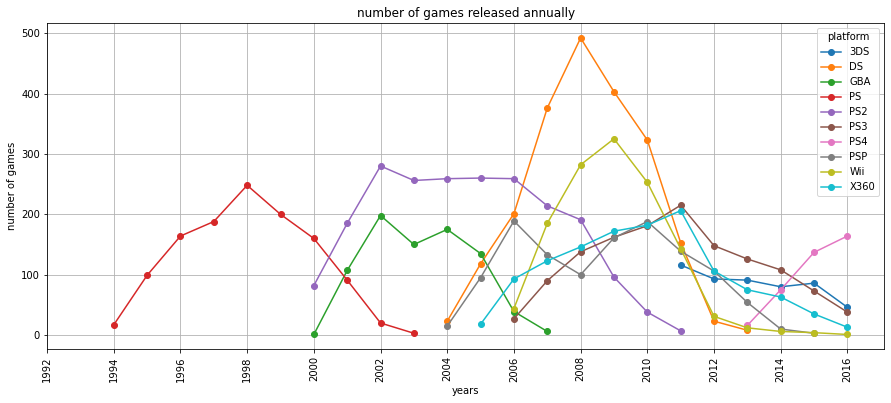

In [53]:
games_df_by_year_convert.plot(grid=True, figsize=(15, 6), title='number of games released annually', \
                              xlabel='years', ylabel='number of games', \
                              linestyle='-', marker='o')
plt.xticks(list(range(1992, 2017, 2)), rotation=90)
plt.show()

Рассчитаем медианный срок жизни платформы

In [54]:
platform_live_cycle = games_df.groupby(['platform']).agg({'year_of_release': 'unique'})

In [55]:
def count_years(lst):
    return len(lst)

In [56]:
platform_live_cycle['year_of_release'] = platform_live_cycle['year_of_release'].apply(count_years)

In [57]:
print('Медианный срок жизни платформы (из всей совокупности рассматрваемых платформ), лет:', int(platform_live_cycle.median()))

Медианный срок жизни платформы (из всей совокупности рассматрваемых платформ), лет: 8


In [58]:
platform_live_cycle_top_10 = []
for idx in top_10_platforms.index:
    platform_live_cycle_top_10.append(int(platform_live_cycle.loc[idx]))

In [59]:
print('Медианный срок жизни платформы (из топ-10), лет:', int(median(platform_live_cycle_top_10)))

Медианный срок жизни платформы (из топ-10), лет: 12


#### Создадим срез данных за актуальный период

На основании данных графика `number of games released annually` можно сделать вывод о том, что актуальным периодом может быть период с **2013 по 2016** гг., так как в этот период попадает часть жизненного цикла современных (на 2016 г.) платформ.

Создадим таблицу с играми, выпущенных с 2013 г. включительно (строки со значением-загушкой `-1` также удаляем, так как в этом анализе нам будет важнен год релиза).

In [60]:
current_period_games_data = games_df_since_1993.query('year_of_release >= 2013')

In [61]:
# проверка
current_period_games_data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
16,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97.0,8.2,M,21.05
23,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97.0,8.1,M,16.27
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,-1.0,-1.0,Unknown,14.63
33,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,5.28,4.19,4.35,0.78,-1.0,-1.0,Unknown,14.60
42,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97.0,8.3,M,12.62


#### Выбор наиболее перспективных платформ

Выберем топ-10 платформ, продавших за период 2013 - 2016 г. наибольшее количество копий своих игр.

In [62]:
promising_platforms = current_period_games_data.groupby('platform') \
                            .agg({'total_sales': 'sum'}) \
                            .sort_values(by='total_sales', ascending=False) \
                            .head(10) \
                            .index \
                            .to_list()

In [63]:
promising_platforms

['PS4', 'PS3', 'XOne', '3DS', 'X360', 'WiiU', 'PC', 'PSV', 'Wii', 'PSP']

Посмотрим на динамику продаж перспективных платформ

In [64]:
platforms_total_sales_to_plot = current_period_games_data[current_period_games_data['platform'].isin(promising_platforms)]

In [65]:
platforms_total_sales_to_plot = platforms_total_sales_to_plot.pivot_table(values='total_sales', index='year_of_release', columns='platform', aggfunc='sum')

In [66]:
platforms_total_sales_to_plot.head()

platform,3DS,PC,PS3,PS4,PSP,PSV,Wii,WiiU,X360,XOne
year_of_release,,,,,,,,,,
2013,56.57,12.38,113.25,25.99,3.14,10.59,8.59,21.65,88.58,18.96
2014,43.76,13.28,47.76,100.00,0.24,11.90,3.75,22.03,34.74,54.07
2015,27.78,8.52,16.82,118.90,0.12,6.25,1.14,16.35,11.96,60.14
2016,15.14,5.25,3.60,69.25,NaN,4.25,0.18,4.60,1.52,26.15


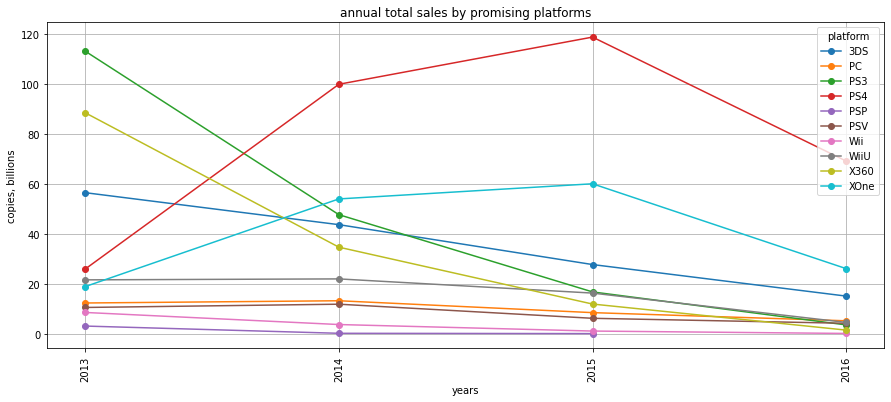

In [67]:
platforms_total_sales_to_plot.plot(grid=True, figsize=(15, 6), title='annual total sales by promising platforms', \
                              xlabel='years', ylabel='copies, billions', \
                              linestyle='-', marker='o')
plt.xticks(list(range(2013, 2017)), rotation=90)
plt.show()

Из графика видно, что все платформы к 2016 г. теряют в продажах игр, но это связано с неполными данными по 2016 г.
К 2015 г. определенно растут продажи игр на таких платформам, как PS4, XOne. Остальные платформы к 2015 г. показывают снижение или отсутствие динамики.

#### График «ящик с усами» по глобальным продажам игр в разбивке по платформам

Построим боксплоты для данных по продажам для каждой из перспективных платформ (топ-10).

In [68]:
current_period_perspective_games_data = current_period_games_data[current_period_games_data['platform'].isin(promising_platforms)]

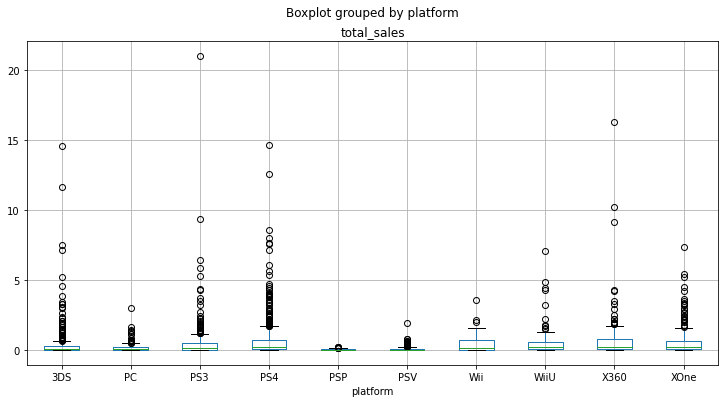

In [69]:
current_period_perspective_games_data.boxplot('total_sales', by='platform', figsize=(12, 6))
plt.show()

Так как довольно много выбросов, удалим их из графика.

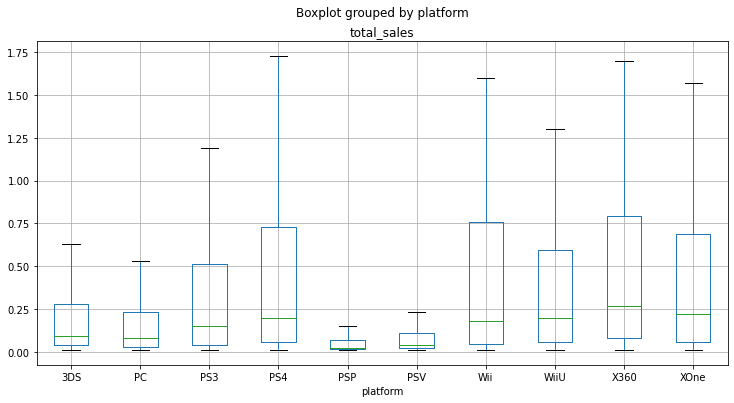

In [70]:
current_period_perspective_games_data.boxplot('total_sales', by='platform', figsize=(12, 6), sym='')
plt.show()

Наибольшее медианное значение количества проданных игр выявлено на платформах PS3 и X360 (около 0.25 млн. копий).
Наименьший разброс значений заметен на платформе PSP (не было частых провалов и взлётов популярности), наибольший межквартильный размах у игр на платформе X360.

**Построение диаграммы рассеяния и расчёт корреляции между отзывами и продажами внутри самой популярной платформы за актуальный период (с 2013 по 2016 г.)**

In [71]:
most_popular_platform = current_period_perspective_games_data.groupby('platform') \
                            .agg({'total_sales': 'sum'}) \
                            .sort_values(by='total_sales', ascending=False) \
                            ['total_sales'].idxmax()

In [72]:
print('Самой популярной платформой по количеству проданных копий является', most_popular_platform)

Самой популярной платформой по количеству проданных копий является PS4


Создаем таблицу данных для самой популярной платформы за актуальный период (с 2013 г.)

In [73]:
most_popular_platform_df = current_period_perspective_games_data[(current_period_perspective_games_data['platform'] == most_popular_platform) \
                                    & (games_df['critic_score'] != -1) \
                                    & (games_df['user_score'] != -1)]

In [74]:
# проверка
most_popular_platform_df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
42,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97.0,8.3,M,12.62
77,FIFA 16,PS4,2015,Sports,1.12,6.12,0.06,1.28,82.0,4.3,E,8.58
92,Call of Duty: Advanced Warfare,PS4,2014,Shooter,2.81,3.48,0.14,1.23,83.0,5.7,M,7.66
94,FIFA 17,PS4,2016,Sports,0.66,5.75,0.08,1.11,85.0,5.0,E,7.60
105,Fallout 4,PS4,2015,Role-Playing,2.53,3.27,0.24,1.13,87.0,6.5,M,7.17


Так как шкала оценки пользователей на порядок меньше шкалы оценок критиков, для построения графика в одной системе координат, сделаем новую колонку `tenfold_user_score` для оценок пользователей, умноженных на 10.

In [75]:
most_popular_platform_df['tenfold_user_score'] = most_popular_platform_df['user_score'] * 10

In [76]:
# проверка
most_popular_platform_df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales,tenfold_user_score
42,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97.0,8.3,M,12.62,83.0
77,FIFA 16,PS4,2015,Sports,1.12,6.12,0.06,1.28,82.0,4.3,E,8.58,43.0
92,Call of Duty: Advanced Warfare,PS4,2014,Shooter,2.81,3.48,0.14,1.23,83.0,5.7,M,7.66,57.0
94,FIFA 17,PS4,2016,Sports,0.66,5.75,0.08,1.11,85.0,5.0,E,7.60,50.0
105,Fallout 4,PS4,2015,Role-Playing,2.53,3.27,0.24,1.13,87.0,6.5,M,7.17,65.0


Построим совмещенные графики зависимости баллов (пользовательские, критиков) и количества проданных копий игр

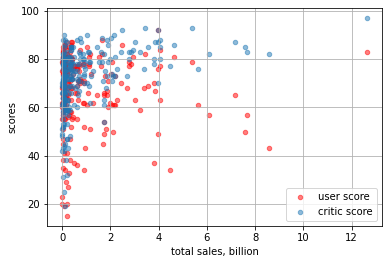

In [77]:
first_ax = most_popular_platform_df.plot(kind='scatter', x='total_sales', y='tenfold_user_score', alpha=0.5, color = 'red', label='user score')
most_popular_platform_df.plot(kind='scatter', grid=True, x='total_sales', y='critic_score', ylabel='scores', xlabel='total sales, billion', alpha=0.5, label='critic score', ax=first_ax)
plt.show()


Увеличим масштаб

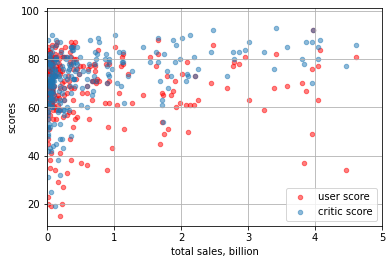

In [78]:
first_ax = most_popular_platform_df.plot(kind='scatter', x='total_sales', y='tenfold_user_score', alpha=0.5, color = 'red', label='user score')
most_popular_platform_df.plot(kind='scatter', grid=True, x='total_sales', y='critic_score', ylabel='scores', xlabel='total sales, billion', alpha=0.5, xlim = (0, 5), label='critic score', ax=first_ax)
plt.legend()
plt.show()

Рассмотрим линейную корреляцию Пирсона для данных о продажах и оценках критиков / пользователей для платформы с наиболее продающемися играми (PS3)

In [79]:
sales_users_score_corr = most_popular_platform_df['total_sales'].corr(most_popular_platform_df['user_score'])
print('Коэффициент корреляции Пирсона для данных о продажах и оценок пользователей: {:.2f}'.format(sales_users_score_corr))

Коэффициент корреляции Пирсона для данных о продажах и оценок пользователей: -0.03


In [80]:
sales_critic_score_corr = most_popular_platform_df['total_sales'].corr(most_popular_platform_df['critic_score'])
print('Коэффициент корреляции Пирсона для данных о продажах и оценок критиков: {:.2f}'.format(sales_critic_score_corr))

Коэффициент корреляции Пирсона для данных о продажах и оценок критиков: 0.41


По графику и по данным коэффициента корреляции Пирсона можно видеть, что связь между оценками пользователей и продажами игр отсутствует (коэффициент корреляции близок к нулю, -0.03). Корреляция между оценками критиков и продажами игр слабая положительная (0.41).

Рассмотрим корреляции между оценками и продажами для всех платформ из топ-10, построив матрицы корреляции.

In [81]:
top_10_perspect_games_df = current_period_perspective_games_data[(current_period_perspective_games_data['critic_score'] != -1) \
                                                               & (current_period_perspective_games_data['user_score'] != -1)]

PS4


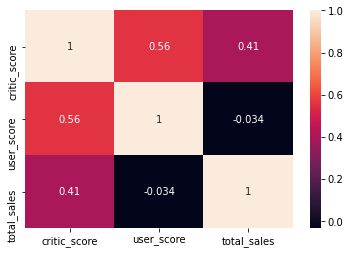

PS3


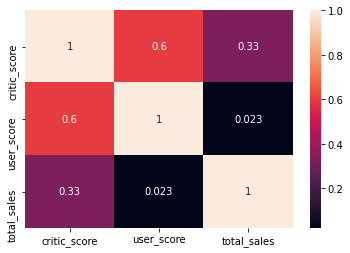

XOne


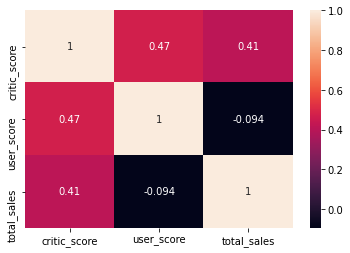

3DS


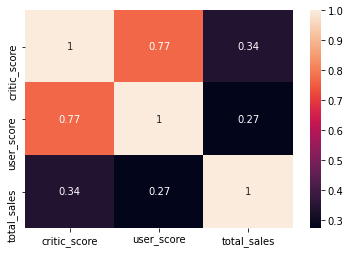

X360


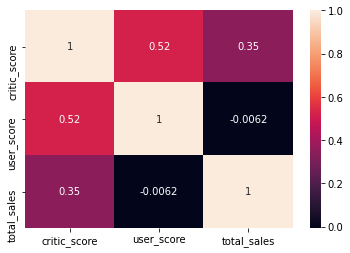

WiiU


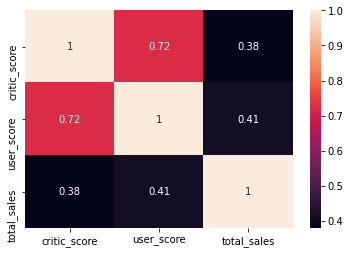

PC


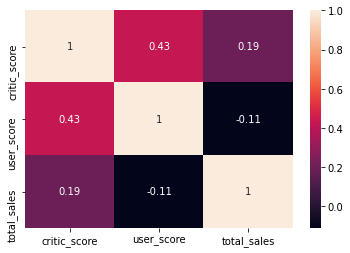

PSV


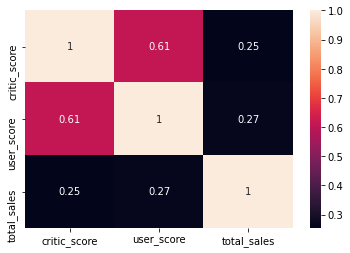

Wii


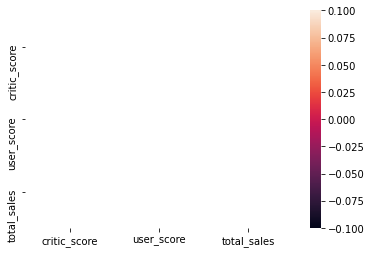

PSP


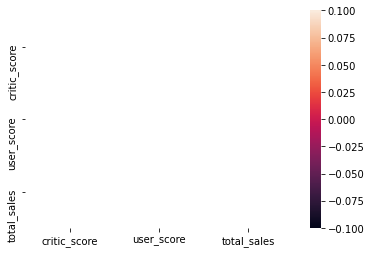

In [82]:
for platform in promising_platforms:
    df_to_corr = top_10_perspect_games_df[top_10_perspect_games_df['platform'] == platform][['critic_score', 'user_score', 'total_sales']]
    df_to_corr = df_to_corr.corr()
    print(platform)
    sns.heatmap(df_to_corr, annot=True)
    plt.show()

По матрицам корреляции Пирсона можно видеть, что связь между оценками и продажами игр существует:

- сильная положительная: такие платформы отсутствуют;
- слабая положительная:
    - платформа X360: оценка критиков - продажи (0.35);
    - платформа PS3: оценка критиков - продажи (0.33);
    - платформа PS4: оценка критиков - продажи (0.41);
    - платформа 3DS: оценка критиков - продажи (0.34);
    - платформа XOne: оценка критиков - продажи (0.41);
    - платформа WiiU: оценка критиков - продажи (0.38), оценка пользователей влияет несколько больше на продажи - 0.41.

По остальным платформам корреляция `оценка критиков - продажи` положительная, но невысокая.

По всем платформам `оценка пользователей - продажи` около нуля или не превышает 0.27 (кроме платформы WiiU - 0.39), из чего можно сделать вывод о том, что оценки критиков являются более существенным фактором, влияющим на продажи, чем пользовательская реакция, однако и они довольно слабо влияют на продажи.

**Для игр на платформах Wii, PSP данные за период с 2013 г. не содержат оценок критиков и игроков, поэтому для них коэффициент корреляции не рассчитан.**

#### Общее распределение игр по жанрам

Посмотрим на общее распределение игр по **жанрам** за актуальный период (2013 - 2016 г.). 

Найдём самые прибыльные и наименее прибыльные жанры.

In [83]:
most_profitable_genres = current_period_perspective_games_data \
                                .groupby('genre') \
                                .agg({'total_sales': 'sum'}) \
                                .sort_values(by='total_sales', ascending=False) \
                                .head() \
                                .index

In [84]:
least_profitable_genres = current_period_perspective_games_data \
                                .groupby('genre') \
                                .agg({'total_sales': 'sum'}) \
                                .sort_values(by='total_sales', ascending=False) \
                                .tail() \
                                .index

Создадим таблицы с данными для самых прибыльных и наименее прибыльных жанров.

In [85]:
genres_df_most_profitable = current_period_perspective_games_data[games_df['genre'].isin(most_profitable_genres)] \
                                    .pivot_table(values='total_sales', columns='platform', index='genre', aggfunc='sum')

In [86]:
genres_df_least_profitable = current_period_perspective_games_data[games_df['genre'].isin(least_profitable_genres)] \
                                    .pivot_table(values='total_sales', columns='platform', index='genre', aggfunc='sum')

Построим график зависимости продаж от жанров для самых **популярных** жанров.

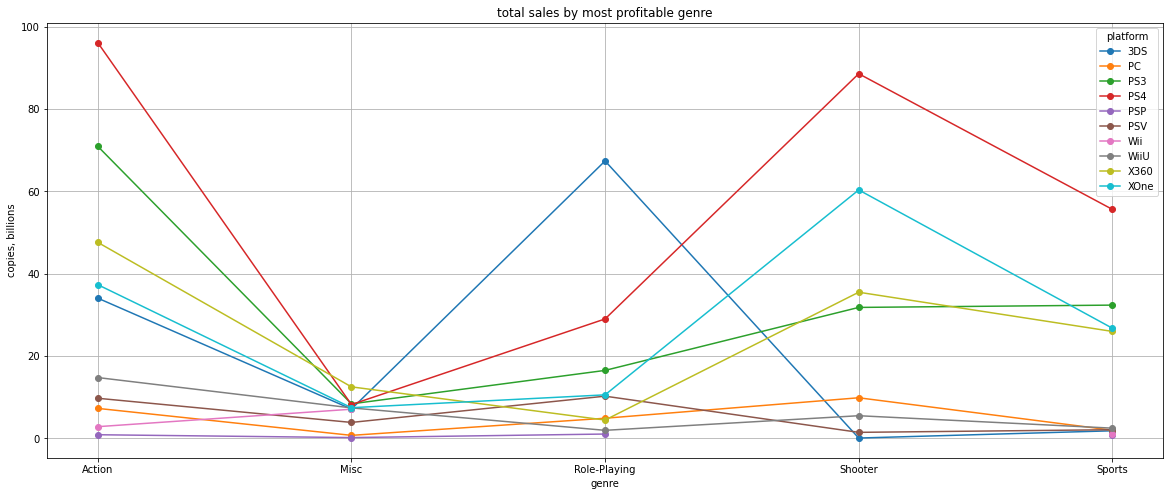

In [87]:
genres_df_most_profitable.plot(grid=True, figsize=(20, 8), title='total sales by most profitable genre', \
                                  xlabel='genre', ylabel='copies, billions', \
                                  linestyle='-', marker='o')
plt.xticks(np.arange(len(genres_df_most_profitable.index)), list(genres_df_most_profitable.index))
plt.show()

Анализ графика показывает следующее:
- самыми **прибыльными** жанрами являются: `action`, `sports`, `shooter`
- платформы, которые выпускают успешные игры в самых прибыльных жанрах: PS4, PS3, X360, XOne

Построим график зависимости продаж от жанров для **наименее популярных** жанров.

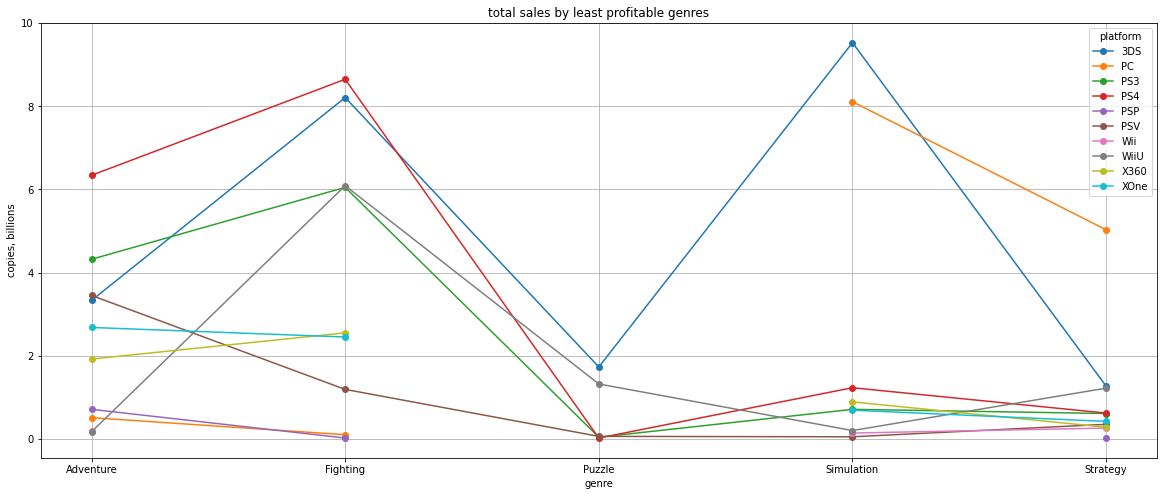

In [88]:
genres_df_least_profitable.plot(grid=True, figsize=(20, 8), title='total sales by least profitable genres', \
                                  xlabel='genre', ylabel='copies, billions', \
                                  linestyle='-', marker='o')
plt.xticks(np.arange(len(genres_df_least_profitable.index)), list(genres_df_least_profitable.index))
plt.show()

Анализ графика показывает следующее:
- самыми **неприбыльными** жанрами являются: `puzzle`, `strategy`
- платформы, которые выпускают успешные игры в самых неприбыльных жанрах: 3DS (`puzzle`), PS (`strategy`)
- самые успешные игры в самом прибльном жанре `action` продались почти 100-млн. тиражом (на 1 платформе, `PS4`), а самые успешные игры в пятёрке наименее прибыльных жанров - около 10 млн. (на 1 платформе, `3DS`).

In [89]:
genres_df_most_profitable = games_df[(games_df['platform'].isin(promising_platforms)) \
                                    & (games_df['genre'].isin(most_profitable_genres))]

In [90]:
genres_df_least_profitable = games_df[(games_df['platform'].isin(promising_platforms)) \
                                    & (games_df['genre'].isin(least_profitable_genres))]

In [91]:
print('Медианное значение количества проданных копий игр наиболее прибыльных жанров, млн.:', genres_df_most_profitable['total_sales'].median())

Медианное значение количества проданных копий игр наиболее прибыльных жанров, млн.: 0.19


In [92]:
print('Медианное значение количества проданных копий игр наименее прибыльных жанров, млн.:', genres_df_least_profitable['total_sales'].median())

Медианное значение количества проданных копий игр наименее прибыльных жанров, млн.: 0.07


**Общее распределение игр по жанрам**

In [93]:
current_period_games_data.head(1)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
16,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97.0,8.2,M,21.05


In [94]:
current_period_games_data_to_plot = current_period_games_data.groupby('genre', as_index=False) \
                                                            .agg(total=('total_sales', 'sum'))                                                            

In [95]:
current_period_games_data_to_plot.head()

,genre,total
0,Action,321.87
1,Adventure,23.64
2,Fighting,35.31
3,Misc,62.82
4,Platform,42.63


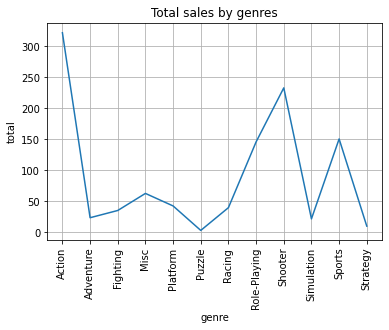

In [96]:
sns.lineplot(data=current_period_games_data_to_plot, x="genre", y="total")

plt.title('Total sales by genres')
plt.grid(True)
plt.xticks(rotation=90)
plt.rcParams['figure.figsize'] = (10,5)
plt.show()

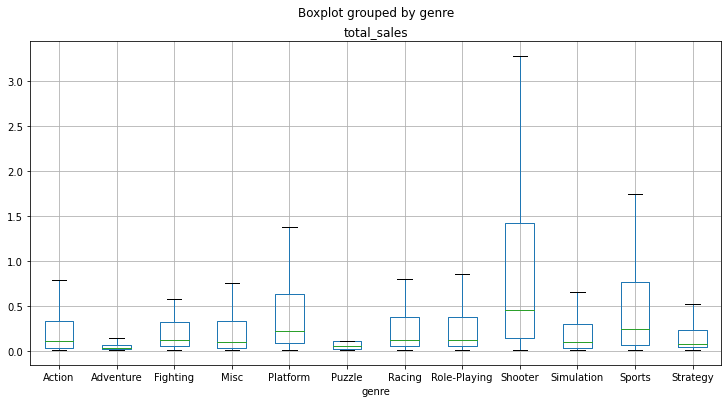

In [97]:
current_period_games_data.boxplot('total_sales', by='genre', figsize=(12, 6), sym='')
plt.show()

При сравнении 2-х графиков можно сделать следующие выводы:
1. Максимальные продажи (в совокупности по всем играм этого жанра) приносят игры жанра `action`, однако, медианные продажи игр этого жанра относительно низки и похожи на игры жанра `simultion`, которые по графику общих продаж почти продаются хуже всех.
2. Самая высокая медианная продажа игр характерна для игр жанра `shooter`, которые по графику общих продаж на 2-м месте.
3. Игры жанров `sports` и `platform` имеют похожие медианные значения продаж, однако на графике общих продаж игры в жанре `platform` продаются довольно плохо.

### Вывод по разделу исследовательского анализа данных

В данном разделе мы выявили:
- количество игр, выпускавшихся в разные годы;
- рассчитали изменения продаж по платформам в течении времени и выявили, что медианный срок платформ от 8 до 12 лет;
- определили актуальный временной период, который можно использовать для дальнейшего исследования пользовательских пристрастий;
- определили лидиров продаж игр в разрезе платформ и жанров;
- построили диаграммы рассеяния и расчёт корреляции между отзывами и продажами внутри самой популярной платформы, внутри платформ из топ-10;
- рассмотрели распределение игр по жанрам.

## Портрет пользователя каждого региона

Определим для пользователя каждого региона (NA, EU, JP):
- самые популярные платформы (топ-5);
- самые популярные жанры (топ-5);
- определим, влияет ли рейтинг ESRB на продажи в отдельном регионе.

Самые популярные платформы (топ-5) для каждого региона для актуального периода (2010 - 2016 г.).

Кодом ниже мы проходим по каждому из 3-х регионов (Северная Америка, Европа, Япония), определяем топ-5 платформ, объединяем данные по выбранным платформам.

In [98]:
popular_platforms = current_period_games_data \
                            [['platform', 'na_sales', 'eu_sales', 'jp_sales']] \
                            .groupby('platform') \
                            .sum()

In [99]:
popular_platforms_list = set()
for region in ['na_sales', 'eu_sales', 'jp_sales']:
    popular_platforms_list.update(popular_platforms[region].sort_values(ascending=False).head().index)

In [100]:
popular_platforms_list = list(popular_platforms_list)

In [101]:
popular_platforms = popular_platforms.loc[popular_platforms_list]

In [102]:
# проверка
popular_platforms.head()

,na_sales,eu_sales,jp_sales
platform,,,
PS4,108.74,141.09,15.96
PSV,5.04,6.10,18.59
WiiU,29.21,19.85,10.88
XOne,93.12,51.59,0.34
PS3,63.50,67.81,23.35


Создадим колонки с долями платформ в общем количестве продаж.

In [103]:
total_na_sales = popular_platforms['na_sales'].sum()

In [104]:
total_eu_sales = popular_platforms['eu_sales'].sum()

In [105]:
total_jp_sales = popular_platforms['jp_sales'].sum()

In [106]:
popular_platforms['na_platform_share'] = popular_platforms['na_sales'] / total_na_sales

In [107]:
popular_platforms['eu_platform_share'] = popular_platforms['eu_sales'] / total_eu_sales

In [108]:
popular_platforms['jp_platform_share'] = popular_platforms['jp_sales'] / total_jp_sales

In [109]:
# проверка
popular_platforms.head()

,na_sales,eu_sales,jp_sales,na_platform_share,eu_platform_share,jp_platform_share
platform,,,,,,
PS4,108.74,141.09,15.96,0.259232,0.392004,0.116123
PSV,5.04,6.10,18.59,0.012015,0.016948,0.135259
WiiU,29.21,19.85,10.88,0.069635,0.055151,0.079162
XOne,93.12,51.59,0.34,0.221994,0.143337,0.002474
PS3,63.50,67.81,23.35,0.151382,0.188403,0.169892


Построим график зависимости доли рынка платформ в разрезе рассматриваемых регионов.

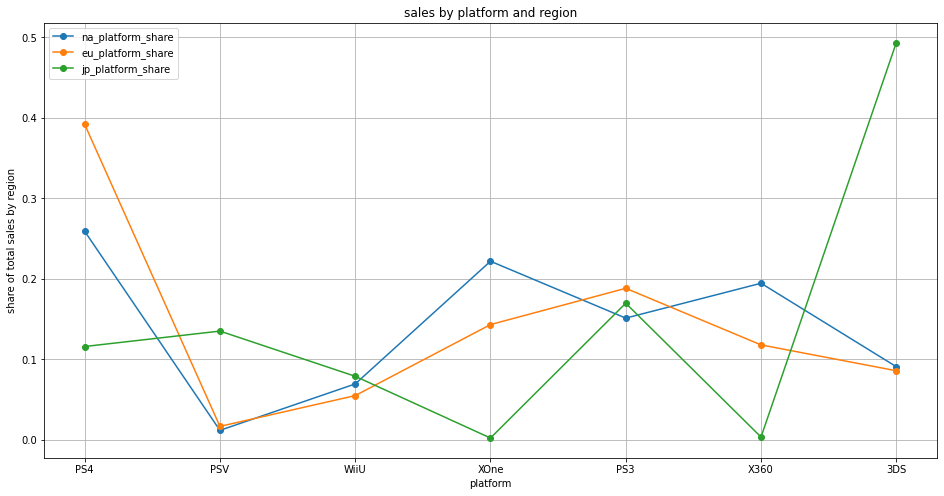

In [110]:
popular_platforms[['na_platform_share', 'eu_platform_share', 'jp_platform_share']] \
                        .plot(grid=True, figsize=(16, 8), title='sales by platform and region', \
                              xlabel='platform', ylabel='share of total sales by region', \
                              linestyle='-', marker='o')
plt.xticks(np.arange(len(popular_platforms.index)), list(popular_platforms.index))
plt.show()

Анализ графика показывает, следующее:
- даже самая популярная платформа не занимает на рынках более 9% для рынков Северной Америки и Европы, однако платформа 3DS в Японии занимаетт почти половину рынка;
- во всех рассматриваемых регионах популярность только 2 платформ соизмеримо одинаково высока: PS3, WiiU;
- пользователи Северной Америки отдают предпочтение играм на платформе XOne, PS4;
- пользователи Европы отдают предпочтение играм на платформах XOne, PS3, PS4;
- тренд популярности платформ среди геймеров Японии часто противоположен тренду Европы и Северной Америки: пользуются популярностью игры на 3DS, PS3, PSV.

Самые популярные жанры (топ-5) для каждого региона.

Кодом ниже мы проходим по каждому из 3-х регионов (Северная Америка, Европа, Япония), определяем топ-5 жанров, объединяем данные по выбранным платформам.

In [111]:
popular_genres = current_period_games_data \
                          [['genre', 'na_sales', 'eu_sales', 'jp_sales']] \
                          .groupby('genre') \
                          .sum()

In [112]:
popular_genres_list = set()
for region in ['na_sales', 'eu_sales', 'jp_sales']:
    popular_genres_list.update(popular_genres[region].sort_values(ascending=False).head().index)

In [113]:
popular_genres_list = list(popular_genres_list)

In [114]:
popular_genres = popular_genres.loc[popular_genres_list]

In [115]:
# проверка
popular_genres.head()

,na_sales,eu_sales,jp_sales
genre,,,
Action,126.05,118.13,40.49
Shooter,109.74,87.86,6.61
Fighting,15.55,8.55,7.65
Racing,12.96,20.19,2.30
Role-Playing,46.40,36.97,51.04


Создадим колонки с долями жанров в общем количестве продаж.

In [116]:
total_na_sales = popular_genres['na_sales'].sum()

In [117]:
total_eu_sales = popular_genres['eu_sales'].sum()

In [118]:
total_jp_sales = popular_genres['jp_sales'].sum()

In [119]:
popular_genres['na_genre_share'] = popular_genres['na_sales'] / total_na_sales

In [120]:
popular_genres['eu_genre_share'] = popular_genres['eu_sales'] / total_eu_sales

In [121]:
popular_genres['jp_genre_share'] = popular_genres['jp_sales'] / total_jp_sales

Построим график зависимости доли рынка жанров в разрезе рассматриваемых регионов.

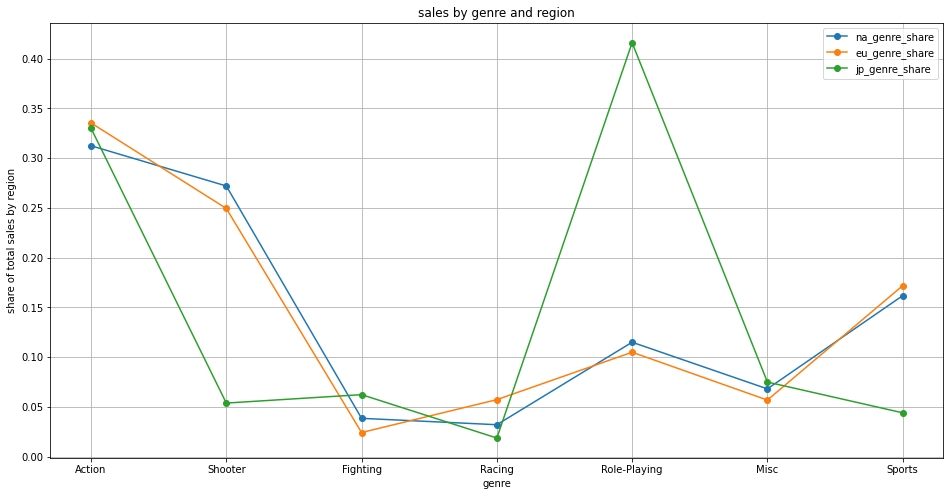

In [122]:
popular_genres[['na_genre_share', 'eu_genre_share', 'jp_genre_share']] \
                        .plot(grid=True, figsize=(16, 8), title='sales by genre and region', \
                              xlabel='genre', ylabel='share of total sales by region', \
                              linestyle='-', marker='o')
plt.show()

Анализ графика показывает, следующее:
- самый популярный жанр среди европейских и севро-американских геймеров - `Action`, в отличие от японских, которые существенно больше другим жанрам предпочитают `Role-Playing`;
- во всех рассматриваемых регионах популярность только 2 жанров одинакова в исследуемых регионах: `Misc`, `Action`, `Racing`, `Fightig`;
- пользователи Северной Америки, в целом, единодушны с геймерами Европы (видимо, имеет значение относительно общее культурное пространство) и отдают предпочтение играм в жанрах `Action`, `Sports`, `Shooter`;
- тренд популярности жанров среди геймеров Японии часто противоположен тренду Европы и Северной Америки: `Role-Playing` существенно лидирует, над другими жанрами. А вот шутеры в Японии нименее популярны (среди топ-5 жанров).

Рассмотрим влияние рейтинга ESRB на продажи в исследуемых регионах в актуальный временной период (2010 - 2016 г.)

In [123]:
games_rating_df = current_period_games_data \
                          [['rating', 'na_sales', 'eu_sales', 'jp_sales']] \
                          .groupby('rating') \
                          .sum()

In [124]:
games_rating_df.head()

,na_sales,eu_sales,jp_sales
rating,,,
E,79.05,83.36,15.14
E10+,54.24,42.69,5.89
M,165.21,145.32,14.11
T,49.79,41.95,20.59
Unknown,89.42,78.91,85.05


Построим график зависимости продаж от рейтинга в разрезе регионов.

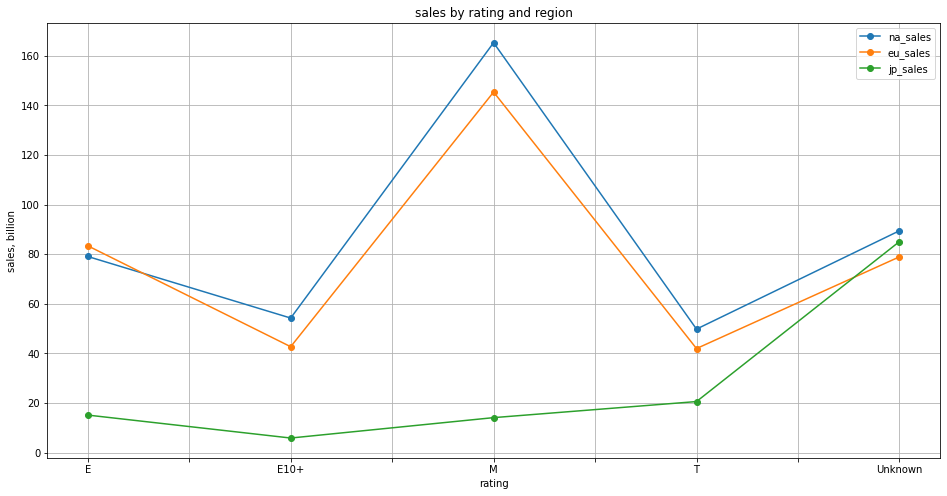

In [125]:
games_rating_df.plot(grid=True, figsize=(16, 8), title='sales by rating and region', \
                              xlabel='rating', ylabel='sales, billion', \
                              linestyle='-', marker='o')
plt.show()

Выводы по графику:
1. В регионе Европы и Северной Америки лучше всего продаются игры с рейтингами:
- 'M' - "для взрослых" (17+);
- 'E' - 'для всех' (6+);
- без рейтинга.
2. В Японии игры без рейтинга значительно лидируют среди игр всех остальных категорий.

Хуже всего во всех регионах продаются игры 'для всех от 10 лет' (10+) ('E10+').

Возможные причины наиболее частой покупки игр без рейтинга, как в Японии, так и в других регионах:
- требования по маркировке игр не являются обязательными;
- возрастная маркировка накладывает соответствующие ограничения на развитие сюжета, аудио- и визуальных приемов, что оограничивает производителя;
- производители игр не хотят ограничивать свою аудиторию.

**Вывод по потрету среднего пользователя:**
- наиболее типичный игрок Северной Америки пользуется платформой PS4 и играет в `Grand Theft Auto` в жанре `Action`;
- типичный игрок из Европы имеет похожие вкусы (возможно, играет в ту же игру), как и игрок из из Северной Америки;
- японский игрок удивленно смотрит на игроков западной культуры и спокойно проходит `Monster Hunter` в жанре `role-playing` на `Nintendo 3DS`;
- никто из них не любит игры в жанре `puzzle`.

## Формулирование и проверка гипотез

### Постановка задачи для проверки гипотез

Проверим 2 гипотезы:
- средние пользовательские рейтинги платформ Xbox One и PC одинаковые;
- средние пользовательские рейтинги жанров Action и Sports разные.

### Формулирование гипотез и их проверка

Сформулируем гипотезы для утверждения "Средние пользовательские рейтинги платформ Xbox One и PC одинаковые":
- Ho: средняя пользовательская оценка платформы Xbox One равна средней пользовательской оценке платформы PC.
- H1: средняя пользовательская оценка платформы Xbox One не равна средней пользовательской оценке платформы PC.

Это гипотеза о равенстве среднего двух генеральных совокупностей по взятым из них выборкам.

Создадим таблицы с данными платформ Xbox One и PC.

In [126]:
x_one_df = current_period_games_data[current_period_games_data['platform'] == 'XOne'][['platform', 'user_score']] \
                      .query('user_score > 0')

In [127]:
# проверка
x_one_df.head()

,platform,user_score
165,XOne,7.9
179,XOne,5.4
242,XOne,6.4
270,XOne,6.2
373,XOne,4.1


In [128]:
pc_df = current_period_games_data[current_period_games_data['platform'] == 'PC'][['platform', 'user_score']] \
                      .query('user_score > 0')

In [129]:
# проверка
pc_df.head()

,platform,user_score
458,PC,3.9
1095,PC,7.9
1351,PC,2.2
1437,PC,6.0
1530,PC,5.4


In [130]:
print('Дисперсия выборки пользовательских оценок для платформы Хbox One:', x_one_df.var().iloc[0])

Дисперсия выборки пользовательских оценок для платформы Хbox One: 1.9069968429360695


In [131]:
print('Дисперсия выборки пользовательских оценок для платформы PC:', pc_df.var().iloc[0])

Дисперсия выборки пользовательских оценок для платформы PC: 3.035892752408882


Так как дисперсии близки (1.9 / 3.0), для формулы вычисления Т-теста применим аргумент равности дисперсии выборок равным True

In [132]:
results = st.ttest_ind(x_one_df['user_score'], pc_df['user_score'], equal_var=True)

Критерий проверки гипотез (p-value) выберем стандартный 0.05.

In [133]:
alpha = 0.05

In [134]:
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу. P-value:', results.pvalue)
else:
    print('Нулевая гипотеза не отвергается. P-value:', results.pvalue)

Нулевая гипотеза не отвергается. P-value: 0.14012658403611647


Так как уровень статистичнеской значимости (p-value) больше критерия (0.05), мы не отвергаем нулевую гипотезу о том, что средняя пользовательская оценка платформы Xbox One равна средней пользовательской оценке платформы PC.

Сформулируем гипотезы для утверждения "Средние пользовательские рейтинги жанров Action и Sports разные":
- Ho: средняя пользовательская оценка жанра Action равна средней пользовательской оценке жанра Sports.
- H1: средняя пользовательская оценка жанра Action не равна средней пользовательской оценке жанра Sports.

Это гипотеза о равенстве среднего двух генеральных совокупностей по взятым из них выборкам.

Создадим таблицы с данными жанров Action и Sports.

In [135]:
action_genre_df = current_period_games_data[current_period_games_data['genre'] == 'Action'][['genre', 'user_score']] \
                      .query('user_score > 0')

In [136]:
# проверка
action_genre_df.head()

,genre,user_score
16,Action,8.2
23,Action,8.1
42,Action,8.3
149,Action,9.1
165,Action,7.9


In [137]:
sports_genre_df = current_period_games_data[current_period_games_data['genre'] == 'Sports'][['genre', 'user_score']] \
                      .query('user_score > 0')

In [138]:
# проверка
sports_genre_df.head()

,genre,user_score
77,Sports,4.3
94,Sports,5.0
126,Sports,4.3
143,Sports,5.7
264,Sports,4.5


In [139]:
print('Дисперсия выборки пользовательских оценок для жанра Action:', action_genre_df.var().iloc[0])

Дисперсия выборки пользовательских оценок для жанра Action: 1.7693609042482705


In [140]:
print('Дисперсия выборки пользовательских оценок для жанра Sports:', sports_genre_df.var().iloc[0])

Дисперсия выборки пользовательских оценок для жанра Sports: 3.180612814465409


Так как дисперсии близки (1.8 / 3.2), для формулы вычисления Т-теста применим аргумент равности дисперсии выборок равным True.


In [141]:
results = st.ttest_ind(action_genre_df['user_score'], sports_genre_df['user_score'], equal_var=True)

Критерий проверки гипотез (p-value) выберем стандартный 0.05.

In [142]:
alpha = 0.05

In [143]:
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу. P-value:', results.pvalue)
else:
    print('Нулевая гипотеза не отвергается. P-value:', results.pvalue)

Отвергаем нулевую гипотезу. P-value: 1.0517832389140023e-27


Так как уровень статистичнеской значимости (p-value) больше критерия (0.05), мы отвергаем нулевую гипотезу о том, что средняя пользовательская оценка жанра Action равна средней пользовательской оценке жанра Sports.

### Вывод по разделу

Проверили 2 гипотезы, по которым сделали 2 вывода:
- средние пользовательские рейтинги платформ Xbox One и PC **одинаковые**;
- средние пользовательские рейтинги жанров Action и Sports **не одинаковые**.

## Вывод исследования

Проведено исследование исторических данных о продажах игр интернет-магазином "Стримчик".

В процессе исследования очищенных и предобработаны данные, пропуски заменены на релевантные значения или значения-"заглушки".

Исследовательский анализ данных позволил выяснить следующее:
- основной пик производства игр пришелся на 2005 - 2015 г. (по данным до 2016 г.);
- медианный срок жизни игровой платформы от 8 до 12 лет;
- все платформы к 2016 г. теряют в продажах игр, но это связано с неполными данными по 2016 г. К 2015 г. определенно растут продажи игр на таких платформам, как PS4, XOne;
- оценки критиков являются более существенным фактором, влияющим на продажи, чем пользовательская реакция, однако корреляция для любых оценок с продажами слабая;
- самыми **прибыльными** жанрами являются: `action`, `sports`, `shooter`;
- самыми **неприбыльными** жанрами являются: `puzzle`, `adventure`, `strategy`;
- даже самая популярная платформа не занимает на рынках более 9% (кроме Японии, там платформа 3DS захватила около 50%);
- пользователи Северной Америки и Европы отдают предпочтение играм в жанрах `Action`, `Sports`, `Shooter` на платформе XOne, PS4;
- тренд популярности платформ среди геймеров Японии часто противоположен тренду Европы и Северной Америки: пользуются популярностью игры `Role-Playing`, `Action` на 3DS, PS4, а в вот шутеры в Японии наименее популярны (среди топ-5 жанров).
- В регионе Европы и Северной Америки лучше всего продаются игры с рейтингами: "для взрослых" (17+); 'для всех' (6+); без рейтинга. В Японии игры без рейтинга значительно лидируют среди игр всех остальных категорий.
- Максимальные продажи (в совокупности по всем играм этого жанра) приносят игры жанра `action`, однако, медианные продажи игр этого жанра относительно низки и похожи на игры жанра `simultion`, которые по графику общих продаж почти продаются хуже всех.

Проверили 2 гипотезы, по которым сделали 2 вывода:
- средние пользовательские рейтинги платформ Xbox One и PC **одинаковые**;
- средние пользовательские рейтинги жанров Action и Sports **не одинаковые**.